In [1]:
import os
import shutil
from pathlib import Path

import pyvista as pv
import ogstools as ot

import matplotlib.pyplot as plt

from meshing import create_rectangle_mesh, create_cube_mesh

# Path

In [2]:
OGS_PATH = None

In [3]:
if OGS_PATH is not None:
    os.environ["OGS_BIN_PATH"] = OGS_PATH
OUT_DIR = Path(os.environ.get("OGS_TESTRUNNER_OUT_DIR", "_out"))
MESH_DIR = OUT_DIR / "mesh"
shutil.rmtree(OUT_DIR, ignore_errors=True)
MESH_DIR.mkdir(parents=True, exist_ok=True)

# 2D mesh

In [4]:
MSH_FILE = MESH_DIR / "rectangle_2d.msh"

create_rectangle_mesh(
        MSH_FILE,
        width=10.0,
        height=10.0,
        mesh_size=1.0,
        center_z=-20.0)


meshes = ot.meshes_from_gmsh(MSH_FILE, log=False)
for name, mesh in meshes.items():
    vtu_path = MESH_DIR / f"{name}.vtu"
    pv.save_meshio(vtu_path, mesh)
    print(f"Saved {vtu_path}")


Saved _out/mesh/domain.vtu
Saved _out/mesh/physical_group_bottom.vtu
Saved _out/mesh/physical_group_right.vtu
Saved _out/mesh/physical_group_top.vtu
Saved _out/mesh/physical_group_left.vtu
Saved _out/mesh/physical_group_domain.vtu


## Plot 

/var/folders/r9/xlx2ppvs42n_h9_kk4w3r57m0000gp/T/ipykernel_33738/1801929542.py:26: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)


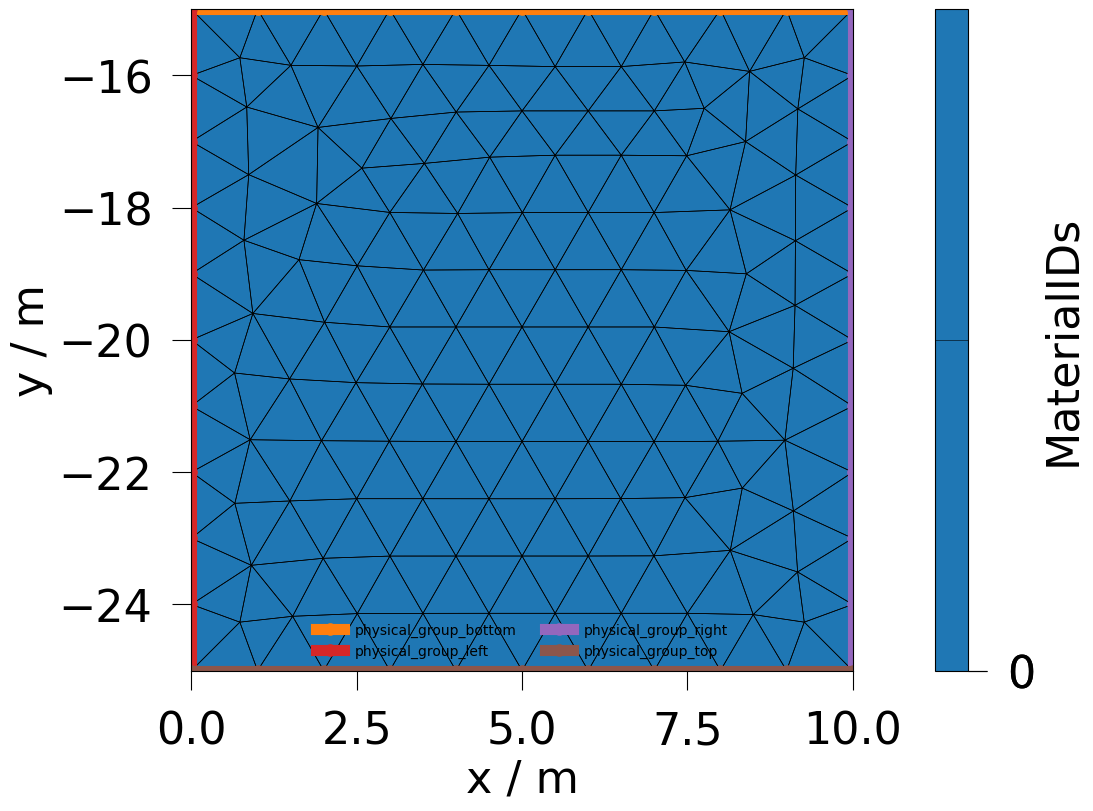

In [5]:
fig = meshes["domain"].plot_contourf(
    "MaterialIDs",
    figsize=(12, 8),
    dpi=100,
    cmap="tab20",
    alpha=0.3,
    linewidth=0,
)
ax = fig.axes[0]
for i, (name, mesh) in enumerate(sorted(meshes.items())):
    if mesh.area:  
        continue
    ls, marker = ("-", "") if "boundary" in name else ("-", "o")
    ot.plot.line(
        mesh,
        ax=ax,
        color=f"C{i}",
        lw=2,
        ls=ls,
        marker=marker,
        markersize=8,
        label=name,
    )
ax.set_aspect("equal")
ax.legend(ncol=2, fontsize=10, frameon=False)
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
plt.show()

# 3D mesh

In [6]:
cube_file = MESH_DIR / "cube_3d.msh"

create_cube_mesh(
        cube_file,        
        width=10.0,
        height=10.0,
        thickness=10.0,
        mesh_size=1.0,
        center_z=-20.0  
    )

cube_meshes = ot.meshes_from_gmsh(cube_file, log=False)
for name, mesh in cube_meshes.items():
    vtu = MESH_DIR / f"cube_{name}.vtu"
    pv.save_meshio(vtu, mesh)
    print(f"Saved {vtu}")


Saved _out/mesh/cube_domain.vtu
Saved _out/mesh/cube_physical_group_points.vtu
Saved _out/mesh/cube_physical_group_edges.vtu
Saved _out/mesh/cube_physical_group_bottom.vtu
Saved _out/mesh/cube_physical_group_top.vtu
Saved _out/mesh/cube_physical_group_front.vtu
Saved _out/mesh/cube_physical_group_back.vtu
Saved _out/mesh/cube_physical_group_left.vtu
Saved _out/mesh/cube_physical_group_right.vtu
Saved _out/mesh/cube_physical_group_volume.vtu


## Plot 

/Volumes/OpenGeoSys/build/release-petsc/.venv/lib/python3.13/site-packages/pyvista/plotting/renderer.py:1846: PyVistaDeprecationWarning: `xlabel` is deprecated. Use `xtitle` instead.
  warnings.warn(
/Volumes/OpenGeoSys/build/release-petsc/.venv/lib/python3.13/site-packages/pyvista/plotting/renderer.py:1852: PyVistaDeprecationWarning: `ylabel` is deprecated. Use `ytitle` instead.
  warnings.warn(
/Volumes/OpenGeoSys/build/release-petsc/.venv/lib/python3.13/site-packages/pyvista/plotting/renderer.py:1858: PyVistaDeprecationWarning: `zlabel` is deprecated. Use `ztitle` instead.
  warnings.warn(


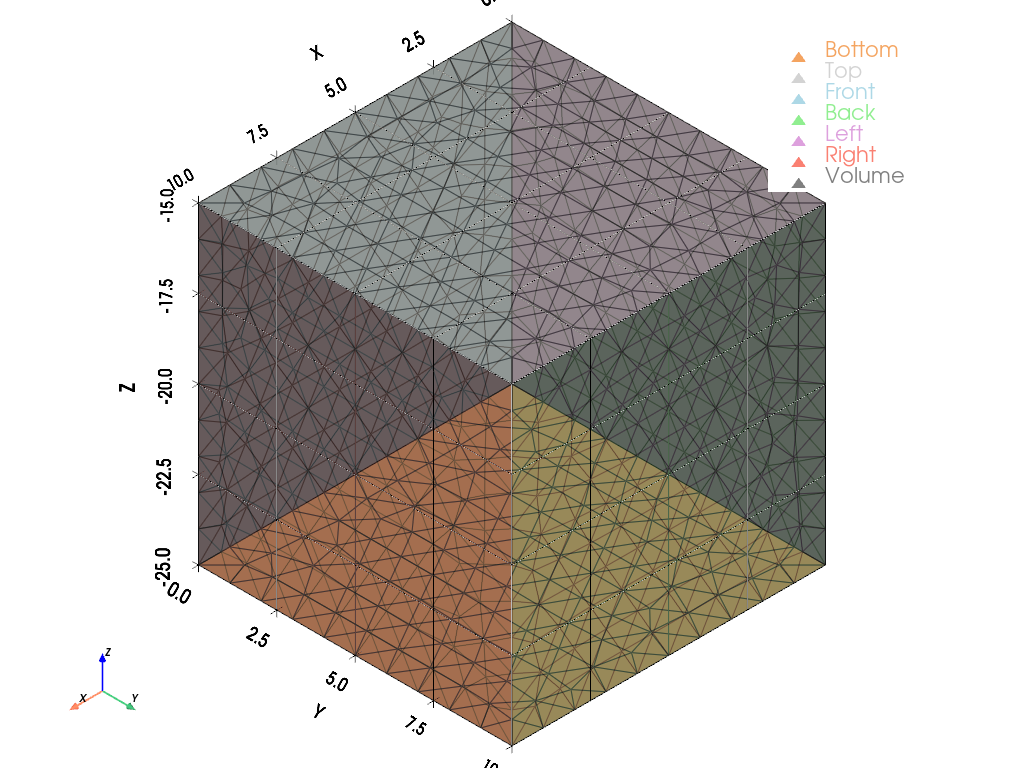

In [7]:
try:
    pv.set_jupyter_backend("static")
except Exception as e:
    print("PyVista backend not set:", e)


faces = {
    "bottom": pv.read(f"{MESH_DIR}/cube_physical_group_bottom.vtu"),
    "top":    pv.read(f"{MESH_DIR}/cube_physical_group_top.vtu"),
    "front":  pv.read(f"{MESH_DIR}/cube_physical_group_front.vtu"),
    "back":   pv.read(f"{MESH_DIR}/cube_physical_group_back.vtu"),
    "left":   pv.read(f"{MESH_DIR}/cube_physical_group_left.vtu"),
    "right":  pv.read(f"{MESH_DIR}/cube_physical_group_right.vtu"),
}
vol    = pv.read(f"{MESH_DIR}/cube_physical_group_volume.vtu")

plotter = pv.Plotter(off_screen=True)

face_colors = {
    "bottom": "sandybrown",
    "top":    "lightgray",
    "front":  "lightblue",
    "back":   "lightgreen",
    "left":   "plum",
    "right":  "salmon",
}
for name, mesh in faces.items():
    plotter.add_mesh(
        mesh,
        color=face_colors[name],
        opacity=0.7,
        show_edges=True,
        label=name.capitalize(),
    )

try:
    vol_surf = vol.extract_surface()
except AttributeError:
    vol_surf = vol
plotter.add_mesh(
    vol_surf,
    style="wireframe",
    color="gray",
    opacity=0.2,
    label="Volume",
)

plotter.show_bounds(
    grid="front",       
    location="outer",   
    all_edges=True,     
    ticks="both",       
    xlabel="X",        
    ylabel="Y",         
    zlabel="Z",         
    font_size=14
)

plotter.add_legend(bcolor="w")
plotter.show_axes()
plotter.enable_parallel_projection()
plotter.view_isometric()
plotter.show()